In [4]:
# ngram, cnn, lstm, hybrid, transformer
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC,SVC
from tensorflow import keras
from tensorflow.keras import layers
import nltk
from nltk.corpus import stopwords

In [5]:
df = pd.read_csv('train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [6]:
nltk.download('stopwords')
stop = stopwords.words('english')
df['text_no_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davismalmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [9]:
X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [10]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(X)

max_features = 1000000
Vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', ngrams=2)
with tf.device('/device:CPU:0'):
    Vectorizer.adapt(X)

vocab = encoder.get_vocabulary()

In [11]:
class CNN1d(tf.keras.Model):
    def __init__(self, conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder):
        super(CNN1d, self).__init__()

        self.encoder = encoder

        vocab = encoder.get_vocabulary()
        
        self.embedding = tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True)
        

        self.conv1 = tf.keras.layers.Conv1D(filters=conv1_filters,
                            kernel_size=conv1_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.conv2 = tf.keras.layers.Conv1D(filters=conv2_filters,
                            kernel_size=conv2_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            )
        self.global_pool = tf.keras.layers.GlobalMaxPool1D(keepdims=False)
        self.dense1 = tf.keras.layers.Dense(dense1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(3, activation="softmax")

    def call(self, x, training=False):
        emb = self.encoder(x)
        emb = self.embedding(emb)
        conv1 = self.conv1(emb)
        conv2 = self.conv2(emb)
        z = tf.concat([conv1, conv2], axis=2)
        z = self.global_pool(z)
        z = self.dense1(z)
        z = self.dense2(z)
        return z

In [12]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)



    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [13]:
def create_model(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1):
    model = CNN1d(conv1_filters, conv1_size, conv2_filters, conv2_size, dense1, encoder)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy']
    )
    return model

def create_ngram():
    model_ngram = tf.keras.Sequential()
    model_ngram.add(Vectorizer)
      
    model_ngram.add(tf.keras.layers.Dense(25, activation='relu'))
    model_ngram.add(tf.keras.layers.Dropout(0.2))
      
    model_ngram.add(tf.keras.layers.Dense(3, activation='softmax'))
      
    model_ngram.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
    return model_ngram

def create_lstm():
    LSTM = tf.keras.Sequential()
    LSTM.add(encoder)
    LSTM.add(tf.keras.layers.Embedding(input_dim=len(vocab),output_dim=64,mask_zero=True))
      
    LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.2,return_sequences=True)))
    LSTM.add(tf.keras.layers.GlobalMaxPool1D())

    LSTM.add(tf.keras.layers.Dropout(0.2))
      
    LSTM.add(tf.keras.layers.Dense(3, activation='softmax'))
      
    LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])
    
    return LSTM

def create_transformer():
    sequence_length = 100
    max_features = 1000000
    # Token locations
    Vectorizer_transformer = tf.keras.layers.TextVectorization(max_tokens=max_features,output_sequence_length=sequence_length) 
    Vectorizer_transformer.adapt(X)
    vocab = Vectorizer_transformer.get_vocabulary()
    vocab_size = len(vocab)


    embed_dim =32  # Embedding size for each token
    num_heads =2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    maxlen = sequence_length
    dropout_rate = 0.3 # Dropout rate of feed forward network 

    ## Build embedding and transformer
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate)

    ## Connect Keras Layers
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string) 
    vec = Vectorizer_transformer(inputs)
    x = embedding_layer(vec)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(3, activation="softmax")(x)

    transformer = keras.Model(inputs=inputs, outputs=outputs) ##Final Model
    
    transformer.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
    return transformer

def create_hybrid(conv_filters, conv_size, lstm_units, dense_units):
    model = tf.keras.Sequential([
      encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=conv_filters,
                            kernel_size=conv_size,
                            padding="same",
                            activation="relu",
                            data_format="channels_last",
                            ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
    # tf.keras.layers.GlobalMaxPool1D(keepdims=False),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
    ])
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=['accuracy'])
    return model

def create_ensemble():
    ensemble = tf.keras.Sequential()
    # for 3 model
    ensemble.add(tf.keras.layers.Dense(36, activation='relu'))
    ensemble.add(tf.keras.layers.Dropout(0.2))

    ensemble.add(tf.keras.layers.Dense(3, activation='softmax'))
    #ensemble.add(tf.keras.layers.InputLayer())

    ensemble.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])

    return ensemble


In [14]:
max_features = 1000000
tfidf_vec = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', sparse=True, ngrams=2)

with tf.device('/device:CPU:0'):
  tfidf_vec.adapt(X)

tdidf = tf.keras.Sequential([
    tfidf_vec])

In [15]:
df = pd.DataFrame(columns = ['model', 'average', 'logloss'])
df

,model,average,logloss


In [30]:
kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X):

    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]


    
    x_train_sparce = tdidf.predict(X_train)
    x_test_sparce = tdidf.predict(X_test)




    cnn = create_model(128, 6, 128, 5, 128)
    ngram = create_ngram()
    LSTM = create_lstm()
    transformer = create_transformer()
    hybrid = create_hybrid(64, 5, 64, 64)
    ensemble = create_ensemble()
    ensemble_with_tdidf = create_ensemble()

    cnn.fit(X_train, y_train, epochs=1 )

    ngram.fit(X_train, y_train, epochs=1, batch_size=64)

    LSTM.fit(X_train, y_train, epochs=2, batch_size=64)
    
    transformer.fit(X_train, y_train, epochs=2, batch_size=64)
    
    hybrid.fit(X_train, y_train, epochs=2, batch_size=64)


    cnn_pred = cnn.predict(X_train)
    ngram_pred = ngram.predict(X_train)
    LSTM_pred = LSTM.predict(X_train)
    transformer_pred = transformer.predict(X_train)
    hybrid_pred = hybrid.predict(X_train)

    cnn_pred_test = cnn.predict(X_test)
    ngram_pred_test = ngram.predict(X_test)
    LSTM_pred_test = LSTM.predict(X_test)
    transformer_pred_test = transformer.predict(X_test)
    hybrid_pred_test = hybrid.predict(X_test)

    X_train_ens = np.hstack([ngram_pred,cnn_pred,LSTM_pred,transformer_pred,hybrid_pred])
    X_test_ens = np.hstack([ngram_pred_test,cnn_pred_test,LSTM_pred_test,transformer_pred_test,hybrid_pred_test])

    X_train_final_tensor = tf.sparse.from_dense(X_train_ens)
    X_test_final_tensor = tf.sparse.from_dense(X_test_ens)
    X_train_concat_tensor = tf.sparse.concat(1,[x_train_sparce, X_train_final_tensor])
    X_test_concat_tensor = tf.sparse.concat(1,[x_test_sparce, X_test_final_tensor])


    ensemble.fit(X_train_ens, y_train, epochs=2, batch_size=128)
    ensemble_with_tdidf.fit(X_train_concat_tensor, y_train, epochs=1, batch_size=256)

    ngram_results = ngram.evaluate(X_test,y_test)
    LSTM_results =LSTM.evaluate(X_test,y_test)
    cnn_results =cnn.evaluate(X_test,y_test)
    transformer_results = transformer.evaluate(X_test,y_test)
    hybrid_results = hybrid.evaluate(X_test,y_test)
    ensemble_results =ensemble.evaluate(X_test_ens,y_test)
    ensemble_with_tdidf_results =ensemble_with_tdidf.evaluate(X_test_concat_tensor,y_test)



    lin_reg = LinearRegression(fit_intercept=False, positive= True)
    lin_reg.fit(X_train_ens, y_train)
    linreg_logloss = log_loss(y_test,lin_reg.predict(X_test_ens))
    linreg_acc = np.sum(np.argmax(y_test, axis = 1) == np.argmax(lin_reg.predict(X_test_ens), axis = 1))/len(np.argmax(y_test, axis = 1))


    lin_reg2 = LinearRegression(fit_intercept=False, positive= True)
    lin_reg2.fit(np.hstack((X_train_ens,ensemble_with_tdidf.predict(X_train_concat_tensor))), y_train)
    linreg2_logloss = log_loss(y_test,lin_reg2.predict(np.hstack((X_test_ens,ensemble_with_tdidf.predict(X_test_concat_tensor)
    ))))
    linreg2_acc = np.sum(np.argmax(y_test, axis = 1) == np.argmax(lin_reg2.predict(np.hstack((X_test_ens,ensemble_with_tdidf.predict(X_test_concat_tensor)
    ))), axis = 1))/len(np.argmax(y_test, axis = 1))


    df_results = pd.DataFrame({"model":['ngram', 'cnn', 'LSTM','transformer','hybrid','ensemble','ensemble_tdidf','lin_reg_1','lin_reg_2'],\
                    "average":[ngram_results[1],cnn_results[1],LSTM_results[1],transformer_results[1],hybrid_results[1],ensemble_results[1],ensemble_with_tdidf_results[1],\
                                linreg_acc, linreg2_acc],\
                    "logloss":[ngram_results[0],cnn_results[0],LSTM_results[0],transformer_results[0],hybrid_results[0],ensemble_results[0],ensemble_with_tdidf_results[0],\
                                linreg_logloss, linreg2_logloss]})

    df = df.append(df_results)

204/204 [==============================] - 7s 33ms/step - loss: 0.6510 - accuracy: 0.7377
Epoch 1/2
204/204 [==============================] - 19s 65ms/step - loss: 0.8207 - accuracy: 0.6186
Epoch 2/2
204/204 [==============================] - 15s 73ms/step - loss: 0.3065 - accuracy: 0.8924
Epoch 1/2
204/204 [==============================] - 14s 63ms/step - loss: 0.9509 - accuracy: 0.5506
Epoch 2/2
204/204 [==============================] - 13s 66ms/step - loss: 0.3491 - accuracy: 0.8652
Epoch 1/2
204/204 [==============================] - 19s 76ms/step - loss: 0.8223 - accuracy: 0.6059
Epoch 2/2
204/204 [==============================] - 16s 78ms/step - loss: 0.3009 - accuracy: 0.8892
Epoch 1/2
102/102 [==============================] - 1s 1ms/step - loss: 0.4249 - accuracy: 0.9378
Epoch 2/2
102/102 [==============================] - 0s 1ms/step - loss: 0.1079 - accuracy: 0.9798


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_7/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_7/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_7/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


204/204 [==============================] - 10s 47ms/step - loss: 0.6413 - accuracy: 0.7447
Epoch 1/2
204/204 [==============================] - 26s 91ms/step - loss: 0.8319 - accuracy: 0.6025
Epoch 2/2
204/204 [==============================] - 17s 86ms/step - loss: 0.3226 - accuracy: 0.8832
Epoch 1/2
204/204 [==============================] - 16s 70ms/step - loss: 0.9754 - accuracy: 0.5216
Epoch 2/2
204/204 [==============================] - 14s 69ms/step - loss: 0.3725 - accuracy: 0.8551
Epoch 1/2
204/204 [==============================] - 19s 79ms/step - loss: 0.8215 - accuracy: 0.6065
Epoch 2/2
204/204 [==============================] - 17s 82ms/step - loss: 0.2958 - accuracy: 0.8907
Epoch 1/2
102/102 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 0.9422
Epoch 2/2
102/102 [==============================] - 0s 1ms/step - loss: 0.1108 - accuracy: 0.9805


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_13/dense_26/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_13/dense_26/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_13/dense_26/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


204/204 [==============================] - 9s 44ms/step - loss: 0.6311 - accuracy: 0.7463
Epoch 1/2
204/204 [==============================] - 26s 91ms/step - loss: 0.8035 - accuracy: 0.6232
Epoch 2/2
204/204 [==============================] - 18s 90ms/step - loss: 0.2967 - accuracy: 0.8914
Epoch 1/2
204/204 [==============================] - 15s 69ms/step - loss: 1.0073 - accuracy: 0.5032
Epoch 2/2
204/204 [==============================] - 14s 70ms/step - loss: 0.4189 - accuracy: 0.8358
Epoch 1/2
204/204 [==============================] - 20s 81ms/step - loss: 0.7799 - accuracy: 0.6268
Epoch 2/2
204/204 [==============================] - 17s 83ms/step - loss: 0.2590 - accuracy: 0.9067
Epoch 1/2
102/102 [==============================] - 0s 1ms/step - loss: 0.8522 - accuracy: 0.6665
Epoch 2/2
102/102 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9769


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_19/dense_40/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_19/dense_40/embedding_lookup_sparse/Reshape:0", shape=(None, 36), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_19/dense_40/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


204/204 [==============================] - 0s 1ms/step - loss: 0.4024 - accuracy: 0.8435


In [31]:
df.groupby('model').describe()

average                                                    \
                 count      mean       std       min       25%       50%   
model                                                                      
LSTM               3.0  0.818990  0.002740  0.816914  0.817437  0.817959   
cnn                3.0  0.806272  0.004262  0.801563  0.804474  0.807386   
ensemble           3.0  0.839624  0.003181  0.837266  0.837815  0.838364   
ensemble_tdidf     3.0  0.844323  0.001068  0.843549  0.843714  0.843879   
hybrid             3.0  0.812810  0.003539  0.809560  0.810925  0.812289   
lin_reg_1          3.0  0.837377  0.003033  0.834993  0.835670  0.836347   
lin_reg_2          3.0  0.845089  0.002526  0.843396  0.843637  0.843879   
ngram              3.0  0.833291  0.003702  0.829324  0.831610  0.833895   
transformer        3.0  0.816844  0.010222  0.805087  0.813452  0.821817   

                                   logloss                                \
                     75%       max   count      mean       std       min   
model                                                                      
LSTM            0.820028  0.822096     3.0  0.465455  0.005926  0.458935   
cnn             0.808626  0.809867     3.0  0.483591  0.005630  0.478460   
ensemble        0.840803  0.843242     3.0  0.439277  0.004406  0.434396   
ensemble_tdidf  0.844710  0.845541     3.0  0.402263  0.001434  0.400776   
hybrid          0.814435  0.816580     3.0  0.490701  0.019450  0.477288   
lin_reg_1       0.838569  0.840791     3.0  0.415738  0.006258  0.408553   
lin_reg_2       0.845936  0.847993     3.0  0.398299  0.002625  0.395660   
ngram           0.835274  0.836653     3.0  0.426563  0.007422  0.419283   
transformer     0.822723  0.823629     3.0  0.461620  0.022916  0.440684   

                                                        
                     25%       50%       75%       max  
model                                                   
LSTM            0.462924  0.466912  0.468714  0.470516  
cnn             0.480579  0.482699  0.486156  0.489613  
ensemble        0.437435  0.440474  0.441718  0.442961  
ensemble_tdidf  0.401576  0.402376  0.403006  0.403637  
hybrid          0.479547  0.481806  0.497407  0.513008  
lin_reg_1       0.413611  0.418668  0.419331  0.419994  
lin_reg_2       0.396992  0.398324  0.399618  0.400911  
ngram           0.422785  0.426287  0.430204  0.434120  
transformer     0.449378  0.458073  0.472088  0.486103

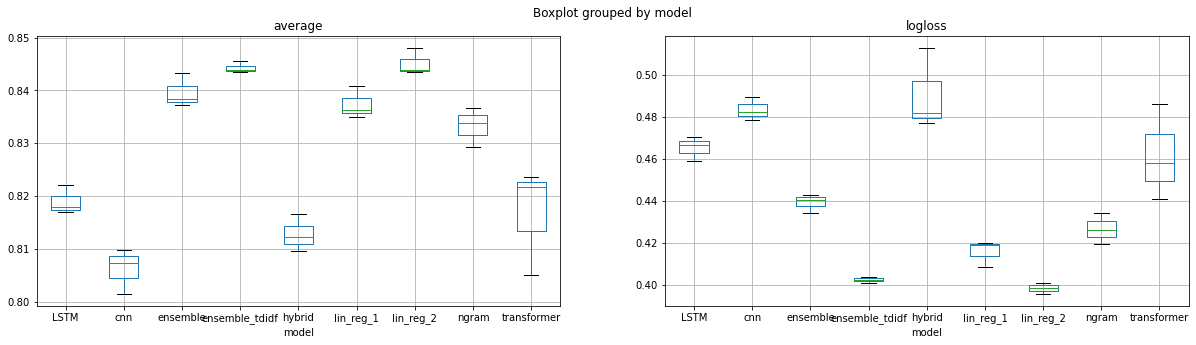

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

df.boxplot('average',by = 'model', ax=ax[0])
df.boxplot('logloss',by = 'model', ax=ax[1])


plt.show()